**有使用Chatgpt、Gemini生成code**

**6.開始為本次作業範圍**

In [2]:
# ========== Colab 檔案上傳 ==========
from google.colab import files
uploaded = files.upload()

Saving O-A0038-003.xml to O-A0038-003.xml


In [3]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam

# ========== 1. 讀取 XML 資料 ==========
tree = ET.parse("O-A0038-003.xml")
root = tree.getroot()

ns = {"ns": "urn:cwa:gov:tw:cwacommon:0.1"}
content = root.find(".//ns:Content", ns).text.strip()
# 先按行拆
lines = content.strip().split("\n")

# 每一行再按逗號拆
rows = [line.split(",") for line in lines]

# 轉成浮點數 (去掉空白)
values = np.array([[float(x) for x in row if x.strip() != ""] for row in rows])

In [4]:
# ========== 2. 建立分類與回歸資料集 ==========
X_class, y_class = [], []
X_reg, y_reg = [], []

for i in range(values.shape[0]):   # i=0 在最上面
    for j in range(values.shape[1]):
        val = values[i, j]
        lon = 120.00 + j * 0.03
        lat = 21.88 + i * 0.03

        # 分類資料 (全部都要)
        label = 0 if val == -999.0 else 1
        X_class.append([lon, lat])
        y_class.append(label)

        # 回歸資料 (只保留有效值)
        if val != -999.0:
            X_reg.append([lon, lat])
            y_reg.append(val)

X_class, y_class = np.array(X_class), np.array(y_class)
X_reg, y_reg = np.array(X_reg), np.array(y_reg)

In [5]:
# ========== 3. 分割資料 ==========
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [6]:
# ========== 4. 分類模型 ==========
normalizer=Normalization(axis=-1)
normalizer.adapt(Xc_train)
clf_model = Sequential([
    normalizer,
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
clf_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
clf_history = clf_model.fit(Xc_train, yc_train, validation_data=(Xc_test, yc_test), epochs=100, batch_size=32, verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# ========== 5. 回歸模型 ==========
normalizer=Normalization(axis=-1)
normalizer.adapt(Xr_train)
reg_model = Sequential([
    normalizer,
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
reg_model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
reg_history = reg_model.fit(Xr_train, yr_train, validation_data=(Xr_test, yr_test), epochs=100, batch_size=32, verbose=0)

In [53]:
# ========== 6. GDA(QDA)模型 ==========
class QDA:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {}
        self.covariances = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.covariances[c] = np.cov(X_c, rowvar=False)
            self.priors[c] = len(X_c) / len(X)

    def _discriminant(self, x, c):
        """Compute the QDA discriminant score for class c"""
        mu = self.means[c]
        sigma = self.covariances[c]
        prior = self.priors[c]

        inv_sigma = np.linalg.inv(sigma)
        det_sigma = np.linalg.det(sigma)
        diff = x - mu

        return -0.5 * np.log(det_sigma) \
               - 0.5 * diff.T @ inv_sigma @ diff \
               + np.log(prior)

    def predict(self, X):
        preds = []
        for x in X:
            scores = [self._discriminant(x, c) for c in self.classes]
            preds.append(self.classes[np.argmax(scores)])
        return np.array(preds)

In [56]:
# ========== 7. 訓練與測試 ==========
qda = QDA()
qda.fit(Xc_train, yc_train)
y_pred = qda.predict(Xc_test)

# 計算準確率
accuracy = np.mean(y_pred == yc_test)
print(f"QDA classification accuracy = {accuracy:.4f}")

QDA classification accuracy = 0.8252


In [64]:
# ========== 8. 決策邊界繪圖 ==========
x_min, x_max = X_class[:,0].min() - 0.1, X_class[:,0].max() + 0.1
y_min, y_max = X_class[:,1].min() - 0.1, X_class[:,1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]

# 計算 discriminant 值
Z0 = np.array([qda._discriminant(x, 0) for x in grid])
Z1 = np.array([qda._discriminant(x, 1) for x in grid])

# 預測類別背景
Z_class = (Z1 > Z0).astype(int).reshape(xx.shape)
Z_diff = (Z1 - Z0).reshape(xx.shape)

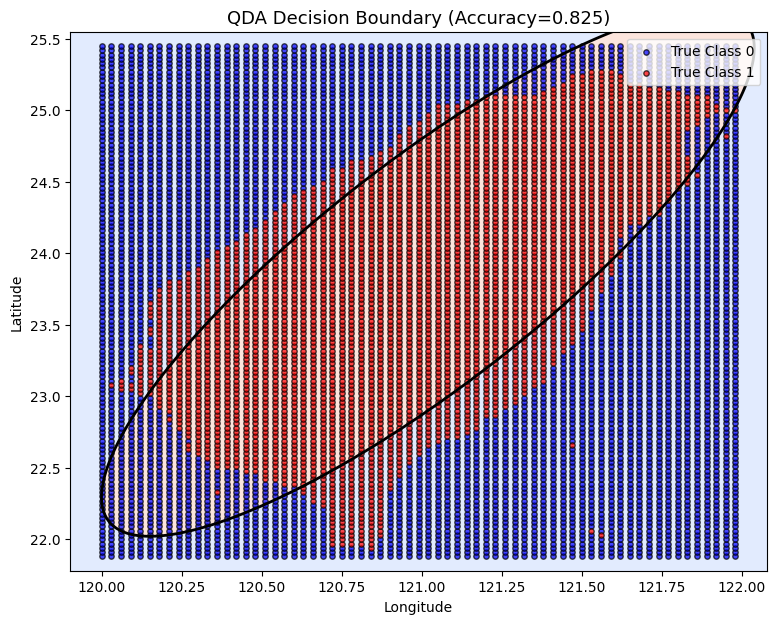

In [69]:
# ========== 9. 繪圖 ==========
plt.figure(figsize=(9,7))

# 背景：模型預測分類
plt.contourf(xx, yy, Z_class, levels=[-0.5,0.5,1.5], alpha=0.25, cmap='coolwarm')

# 決策邊界：Z_diff = 0
plt.contour(xx, yy, Z_diff, levels=[0], colors='black', linewidths=2)

# 真實資料點
plt.scatter(X_class[y_class==0,0], X_class[y_class==0,1],
            c='blue', label='True Class 0', s=15, alpha=0.7, edgecolor='k')
plt.scatter(X_class[y_class==1,0], X_class[y_class==1,1],
            c='red', label='True Class 1', s=15, alpha=0.7, edgecolor='k')

plt.title(f"QDA Decision Boundary (Accuracy={accuracy:.3f})", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

Combined model sample predictions:
Input: [120.    21.88], C(x)=0, R(x)=33.94, h(x)=-999.00
Input: [120.03  21.88], C(x)=0, R(x)=33.78, h(x)=-999.00
Input: [120.06  21.88], C(x)=0, R(x)=33.62, h(x)=-999.00
Input: [120.09  21.88], C(x)=0, R(x)=33.48, h(x)=-999.00
Input: [120.12  21.88], C(x)=0, R(x)=33.39, h(x)=-999.00


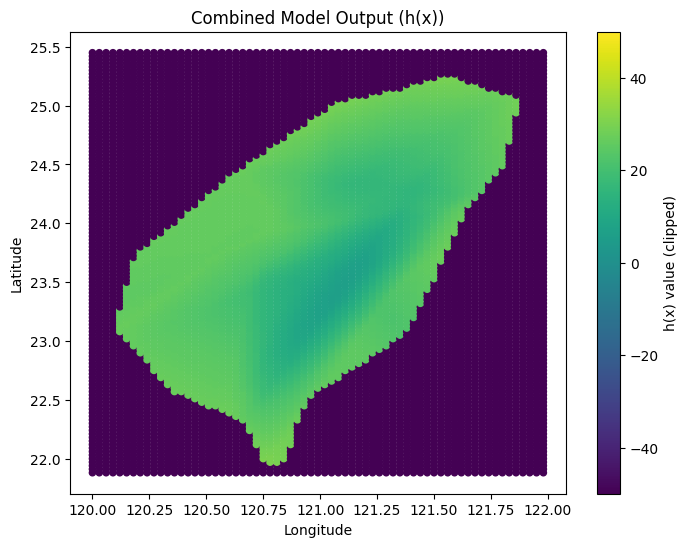

In [75]:
# ========== 10. Combine classification and regression models ==========

def combined_model(X):
    """
    結合分類與回歸模型。
    若分類模型預測為1，則回傳回歸模型的預測；
    否則回傳 -999。
    """
    # C(x) 的預測結果 (sigmoid 輸出 > 0.5 視為 1)
    C_pred = (clf_model.predict(X, verbose=0) > 0.5).astype(int).flatten()

    # R(x) 的預測結果
    R_pred = reg_model.predict(X, verbose=0).flatten()

    # h(x) = piecewise 結果
    h_pred = np.where(C_pred == 1, R_pred, -999)
    return h_pred, C_pred, R_pred


# ========== 測試 combined model ==========
h_pred, C_pred, R_pred = combined_model(X_class)

# 驗證結果
print("Combined model sample predictions:")
for i in range(5):
    print(f"Input: {X_class[i]}, C(x)={C_pred[i]}, R(x)={R_pred[i]:.2f}, h(x)={h_pred[i]:.2f}")

# ========== 繪圖觀察 ==========
plt.figure(figsize=(8,6))
plt.scatter(X_class[:,0], X_class[:,1], c=h_pred, cmap='viridis', s=20, vmin=-50, vmax=50)
plt.colorbar(label="h(x) value (clipped)")
plt.title("Combined Model Output (h(x))")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()